In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import scipy.stats as stats
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### Exploratory Data Analysis

In [34]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Since there are no null values, let's try to brief other part of dataset.

In [35]:
x = boston.drop('MEDV',axis=1)
y = boston[['MEDV']]

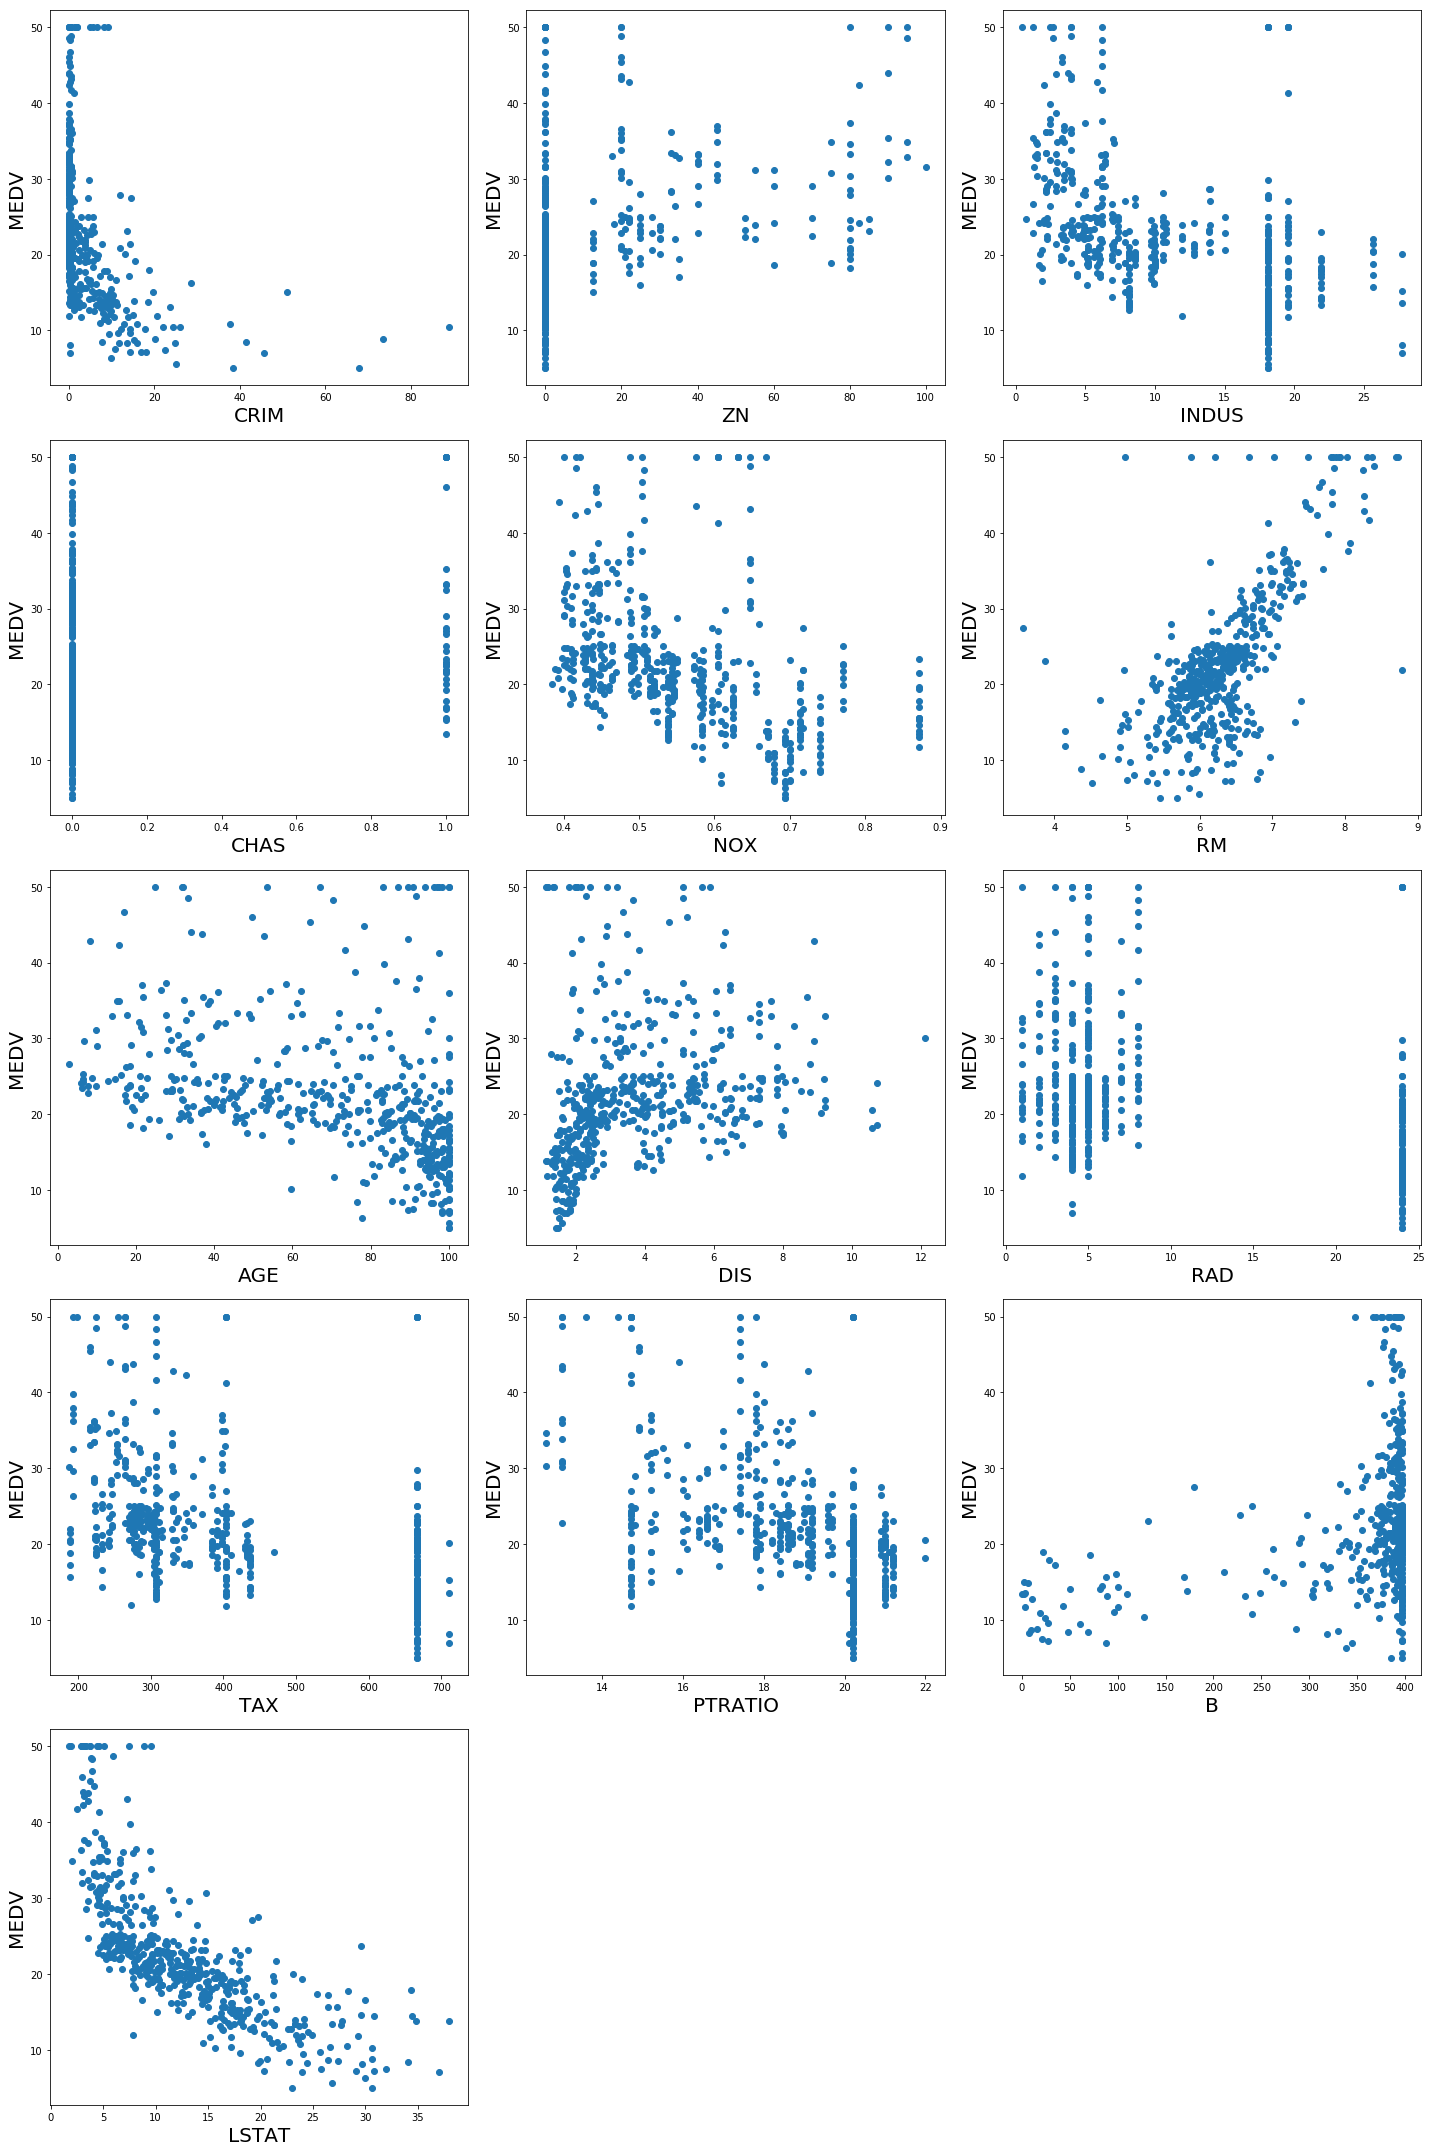

In [36]:
plt.figure(figsize=(20,30), facecolor='white')
plotnumber = 1

for column in x:
    if plotnumber<=15 :
        ax = plt.subplot(5,3,plotnumber)
        plt.scatter(x[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('MEDV',fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [37]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(x)

### Multicollinearity Check 

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = x.columns
vif

,VIF,Features
0,1.792192,CRIM
1,2.298758,ZN
2,3.991596,INDUS
3,1.073995,CHAS
4,4.393720,NOX
5,1.933744,RM
6,3.100826,AGE
7,3.955945,DIS
8,7.484496,RAD
9,9.008554,TAX


Above table shows that there is high multicollinearity in RAD & TAX Feature, which means we need to remove these feature from our model. Otherwise it will impact the overall ability of effecient model. And also in scatterplot it has been seem that there is no such linear relationship between MDEV & these columns. This means we can simply remove these features.

In [40]:
x = boston.drop(['MEDV','RAD','TAX'],axis=1)
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(x)

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = x.columns
vif

,VIF,Features
0,1.478206,CRIM
1,2.154483,ZN
2,3.179166,INDUS
3,1.057805,CHAS
4,3.901348,NOX
5,1.872532,RM
6,3.075755,AGE
7,3.954443,DIS
8,1.496077,PTRATIO
9,1.316559,B


In [52]:
lm = LinearRegression ()
lm.fit(X_scaled,y)
print('Coeffecients of Model is',lm.coef_)
print('Intercept of Model is',lm.intercept_)

Coeffecients of Model is [[-0.52791652  0.96729504 -0.31410493  0.7828009  -1.68953392  2.90193889
  -0.1207767  -3.13199012 -1.75462336  0.74831126 -3.67980321]]
Intercept of Model is [22.53280632]


In [54]:
lm.score(X_scaled,y)

0.7292505252078052

In [59]:
def adjuster_r2(a,b):
    r2 = lm.score(a,b)
    N = boston.shape[0]
    P = x.shape[1]
    return 1- ((1-r2) * (N-1))/(N-P-1)

In [60]:
adjuster_r2(X_scaled,y)

0.7232216907488698

This means if we use all the features except RAD & TAX our model will give us 72.32 Accuracy which is not as bad. But we should also try to explore statistical summary of our model, and do backward elimination if required. <br>
Also we should perform hypothesis testing if required.

### Statistical Summary of Model & Backward Elimination

In [61]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [67]:
x1 = sm.add_constant(X_scaled)
model = sm.OLS(y,x1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 24 Mar 2021   Prob (F-statistic):          2.00e-132
Time:                        01:36:32   Log-Likelihood:                -1509.7
No. Observations:                 506   AIC:                             3043.
Df Residuals:                     494   BIC:                             3094.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.215    104.755      0.000      22.110      22.955
x1            -0.5279      0.262     -2.019      0.044      -1.042      -0.014
x2             0.9673      0.316      3.064      0.002       0.347       1.588
x3            -0.3141      0.384     -0.819      0.413      -1.068       0.439
x4             0.7828      0.221      3.538      0.000       0.348       1.217
x5            -1.6895      0.425     -3.977      0.000      -2.524      -0.855
x6             2.9019      0.294      9.859      0.000       2.324       3.480
x7            -0.1208      0.377     -0.320      0.749      -0.862       0.620
x8            -3.1320      0.428     -7.322      0.000      -3.972      -2.292
x9            -1.7546      0.263     -6.669      0.000      -2.272      -1.238
x10            0.7483      0.247      3.032      0.003       0.263       1.233
x11           -3.6798      0.369     -9.983      0.000      -4.404      -2.956
==============================================================================
Omnibus:                      193.860   Durbin-Watson:                   1.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              958.429
Skew:                           1.628   Prob(JB):                    7.58e-209
Kurtosis:                       8.904   Cond. No.                         5.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
p_valueslst = list(model.pvalues)

In [77]:
H0 = 'There is no relation ship between feature & MDEV value'
H1 = 'There is relationship between feature & MDEV value'
for i in p_valueslst:
    feature = i
    if i <0.05:
        print('Reject null Hypothesis i.e.',f'There is relationship between {feature} & MDEV value')
    else:
        print('Accept Null Hypothesis i.e.',f'There is no relationship between {feature} & MDEV value')

Reject null Hypothesis i.e. There is relationship between 0.0 & MDEV value
Reject null Hypothesis i.e. There is relationship between 0.044065923919658606 & MDEV value
Reject null Hypothesis i.e. There is relationship between 0.0023056195369423 & MDEV value
Accept Null Hypothesis i.e. There is no relationship between 0.41318955324925166 & MDEV value
Reject null Hypothesis i.e. There is relationship between 0.0004405748175315905 & MDEV value
Reject null Hypothesis i.e. There is relationship between 8.034203620860839e-05 & MDEV value
Reject null Hypothesis i.e. There is relationship between 4.7294832917388085e-21 & MDEV value
Accept Null Hypothesis i.e. There is no relationship between 0.7489833366221087 & MDEV value
Reject null Hypothesis i.e. There is relationship between 9.98238323598371e-13 & MDEV value
Reject null Hypothesis i.e. There is relationship between 6.910646981402028e-11 & MDEV value
Reject null Hypothesis i.e. There is relationship between 0.00255754380405441 & MDEV value


Above hypothesis testing shows that we can also exclude DIS feature since it is not showing a better relationship with MDEV value. Also its P value is greater than 0.05. <br>
Let's try to create our model excluding this feature and figure it out if this will improve the model's accuracy. <br>
Basically we are doing backward elimination.

In [78]:
x.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,18.7,396.90,5.33


### Model creation excluding DIS feature! 

In [82]:
x = boston.drop(['MEDV','RAD','TAX','DIS'],axis=1)
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(x)
lm = LinearRegression ()
lm.fit(X_scaled,y)
print('Coeffecients of Model is',lm.coef_)
print('Intercept of Model is',lm.intercept_)

Coeffecients of Model is [[-0.28034592 -0.00460545  0.32373322  0.81242049 -0.762487    3.19797724
   0.68547942 -1.95481538  0.78920606 -3.78278351]]
Intercept of Model is [22.53280632]


In [83]:
lm.score(X_scaled,y)

0.6998664252843607

In [84]:
adjuster_r2(X_scaled,y)

0.6938031207446509

Above model shows that even after removing DIS feature, our model accuracy drastically goes down. So we cannot remove this feature.

In [86]:
x = boston.drop(['MEDV','RAD','TAX'],axis=1)
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(x)
lm = LinearRegression ()
lm.fit(X_scaled,y)
print('Coeffecients of Model is',lm.coef_)
print('Intercept of Model is',lm.intercept_)
print(lm.score(X_scaled,y))
adjuster_r2(X_scaled,y)

Coeffecients of Model is [[-0.52791652  0.96729504 -0.31410493  0.7828009  -1.68953392  2.90193889
  -0.1207767  -3.13199012 -1.75462336  0.74831126 -3.67980321]]
Intercept of Model is [22.53280632]
0.7292505252078052


0.7232216907488698

Let's create scatter and best line fit for RM Feature

In [ ]:
# create a DataFrame with the minimum and maximum values of TV
X_new = pd.DataFrame({'RM': [boston.RM.min(), boston.RM.max()]})
X_new.head()

# make predictions for those x values and store them
preds = lm.predict(X_new)
preds


# first, plot the observed data
data.plot(kind='scatter', x='MDEV', y='RM')

# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)

###  Saving Model as pickle file

In [95]:
# saving the model to the local file system
filename = 'Bostonfinalized_model.pickle'
pickle.dump(lm, open(filename, 'wb'))

In [103]:
# prediction using the saved model
loaded_model = pickle.load(open(filename, 'rb'))
a=loaded_model.predict(scaler.transform([[1,1,1,1,1,1,1,1,1,1,1]]))
a

array([[18.95747036]])